In [2]:
import numpy as np 

class NaiveBayes:
    def __init__(self):
        self.prior = None 
        self.num_classes = None
        self.vocab_size = None
        self.count_matrix = None
        self.inv_count_matrix = None # To store when certain word is not present in a class
        self.words_per_class = None
        self.class_proportions = None # Prior probabilities of each class
        self.alpha = 1 # Laplace smoothing 
        
    def find_instances(self, X_i: np.ndarray):
        instances = np.zeros((self.vocab_size, 1))
        instances = np.sum(X_i, axis=0)
        return instances
    
    def find_inv_instances(self, X_i: np.ndarray):
        inv_instances = np.zeros((self.vocab_size, 1))
        inv_instances = np.sum(X_i == 0, axis=0) # Find number of times a word is not present in a class
        return inv_instances
        # Number of times a word is not present in a class
        # inv_instances = np.zeros((self.vocab_size, 1))

    
    def find_total_words(self, X: np.ndarray):
        # Find total words in a class
        total_words = np.sum(X)
        return total_words
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        self.num_classes = np.max(y) + 1 # Zero-indexed
        # self.count_matrix = np.ones((self.num_classes, X.shape[1])) # Laplace smoothing
        self.count_matrix = np.zeros((self.num_classes, X.shape[1]))
        # self.words_per_class = np.ones((self.num_classes, 1)) * X.shape[1] # Laplace smoothing
        self.words_per_class = np.zeros((self.num_classes, 1))
        self.inv_count_matrix = np.zeros((self.num_classes, X.shape[1]))
        self.vocab_size = X.shape[1]
        self.class_proportions = np.zeros((self.num_classes, 1))
        for i in range(self.num_classes):
            self.class_proportions[i] = np.sum(y == i) / y.shape[0]
            y_class = (np.argwhere(y == i))[:, 0]
            X_class = X[y_class] # Features for class i
            instances = self.find_instances(X_class)
            inv_instances = self.find_inv_instances(X_class)
            total_words = self.find_total_words(X_class)
            self.count_matrix[i, :] += instances.reshape((self.count_matrix[i, :].shape))
            self.inv_count_matrix[i, :] += inv_instances.reshape((self.inv_count_matrix[i, :].shape))
            self.words_per_class[i] += total_words
    
    def find_probabilities(self, X: np.ndarray):
        probabilities = np.zeros((X.shape[0], self.num_classes))
        X_absent = X == 0
        for i in range(X.shape[0]):
            log_probs_present = np.sum(np.log((self.alpha+self.count_matrix)/(self.alpha*self.vocab_size+self.words_per_class)) * X[i, :], axis=1) # Power of X is multiplied after log
            log_probs_absent = np.sum(np.log(1-(self.alpha+self.count_matrix)/(self.alpha*self.vocab_size+self.words_per_class)) * X_absent[i, :], axis=1)
            log_probs = log_probs_present + log_probs_absent + np.log(self.class_proportions).reshape(log_probs_present.shape)
            probs = np.exp(log_probs - np.max(log_probs))
            probs = probs / np.sum(probs)
            probabilities[i, :] = probs
        return probabilities

    def predict(self, X: np.ndarray):
        probabilities = self.find_probabilities(X)
        predictions = np.argmax(probabilities, axis=1)
        return predictions
    
    def evaluate_acc(self, X: np.ndarray, y: np.ndarray):
        predictions = self.predict(X).reshape((y.shape))
        accuracy = np.sum(predictions == y) / y.shape[0]
        return accuracy
    
    def encode_y(self, y):
        y = np.reshape(y, (y.size, 1))
        encoded_y = np.broadcast_to(y, (y.size, self.num_classes)).copy()
        for i in range(self.num_classes):
            class_num = i + 1 # Not zero indexed
            encoded_y[:, i] = encoded_y[:, i] == class_num
        return encoded_y
    
    def compute_F1(self, X: np.ndarray, y: np.ndarray):
        y_encoded = self.encode_y(y)
        y_hat_encoded = self.encode_y(self.predict(X))

        f1_scores = []
        recalls = []
        precisions = []

        epsilon = 1e-8

        for i in range(y_encoded.shape[1]):
            y_column = y_encoded[:, i]
            y_hat_column = y_hat_encoded[:, i]
            y_true = y_column == 1
            y_hat_true = y_hat_column == 1
            true_positives = np.sum((y_true == 1) & (y_hat_true == 1))
            false_positives = np.sum((y_true == 0) & (y_hat_true == 1))
            false_negatives = np.sum((y_true == 1) & (y_hat_true == 0))

            precision = true_positives / (true_positives + false_positives + epsilon)
            recall = true_positives / (true_positives + false_negatives + epsilon)
            f1_score = (2 * precision * recall) / (precision + recall + epsilon)
            
            f1_scores[i] = f1_score
            precisions[i] = precision
            recalls[i] = recall

        return f1_scores, recalls, precisions
                
if __name__ == "__main__":
    from sklearn.feature_extraction.text import CountVectorizer
    text = ["Hello my name is james james",
    "my python notebook haha programming",
    "james trying to hello james create create a big dataset",
    "python programming is fun haha",
    "python programming is fun haha"]
    coun_vect = CountVectorizer()
    # Print which word is assigned which index
    mat = coun_vect.fit_transform(text)
    print(coun_vect.get_feature_names_out())
    X = mat.toarray()
    y = np.array([0, 1, 0, 1, 0])
    nb = NaiveBayes()
    nb.fit(X, y)
    # nb.find_probabilities(X)
    print(nb.predict(X))


['big' 'create' 'dataset' 'fun' 'haha' 'hello' 'is' 'james' 'my' 'name'
 'notebook' 'programming' 'python' 'to' 'trying']
[0 1 0 1 1]


In [3]:
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
dataset = load_dataset("emotion", cache_dir="./data")

In [5]:
# Tokenize the dataset
vectorizer = CountVectorizer()
# Extract text and labels
X = vectorizer.fit_transform(dataset["train"]["text"])
# dataset["train"]["text"]
X = X.toarray()
import numpy as np 
np.argwhere(X[0, :] == 1)
y = np.array(dataset["train"]["label"]).reshape(-1, 1)

In [6]:
X_test = vectorizer.transform(dataset["test"]["text"])
X_test = X_test.toarray()
y_test = np.array(dataset["test"]["label"]).reshape(-1, 1)

In [10]:
# from naive_bayes import NaiveBayes
# Train the model
model = NaiveBayes()
model.fit(X, y)
# Predict on the test set
# y_pred = model.predict(X_test)
alpha_test_list = [0.1, 0.5, 1, 5, 10, 50, 100]
acc_list = []
f1_list = []
recall_list = []
precision_list = []

for alpha in alpha_test_list:
    model.alpha = alpha
    accuracy = model.evaluate_acc(X_test, y_test)
    acc_list.append(accuracy)

    f1, recall, precision = model.compute_F1(X_test, y_test)
    f1_list.append(f1)
    recall_list.append(recall)
    precision_list.append(precision)

# Convert lists to arrays
f1_array = np.array(f1_list)
recall_array = np.array(recall_list)
precision_array = np.array(precision_list)

# Print the final results
#print("F1 Score:", f1_list)
#print("Recall:", recall_list)
#print("Precisions:", precision_list)
#print("Accuracy:", acc_list)

print("Accuracy:", acc_list)
print("F1:", f1_array)
print("Precision:", precision_array)
print("Recall:", recall_array)

Accuracy: 0.389
F1: [0.5354391332090113, 0.0, 0.0, 0.0, 0.0, 0.0]
Precision: [0.3655970541800863, 0.0, 0.0, 0.0, 0.0, 0.0]
Recall: [0.9999999999856115, 0.0, 0.0, 0.0, 0.0, 0.0]


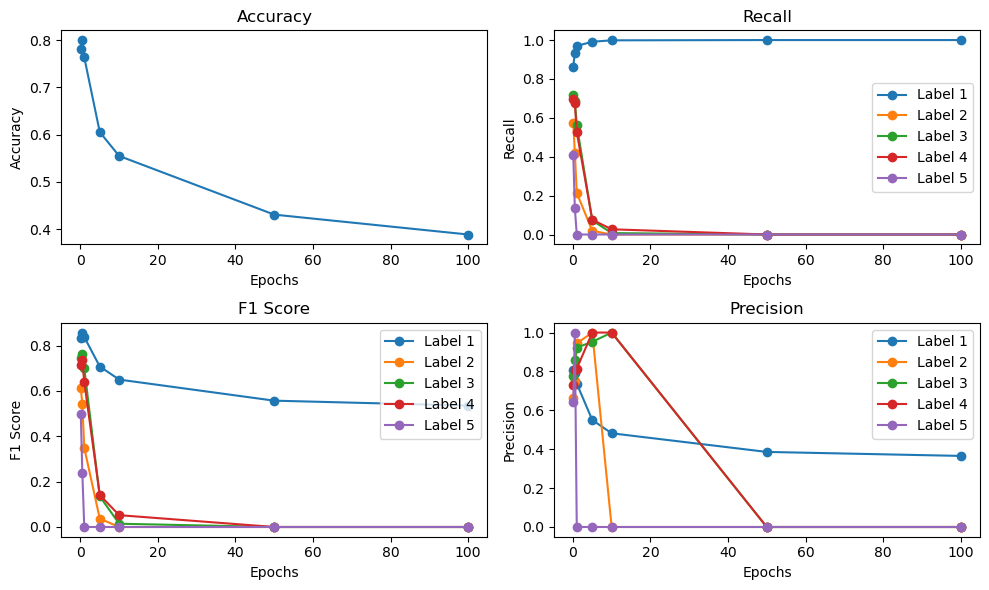

In [13]:
import matplotlib.pyplot as plt

model = NaiveBayes()
model.fit(X, y)
# Predict on the test set
# y_pred = model.predict(X_test)
alpha_test_list = [0.1, 0.5, 1, 5, 10, 50, 100]

epochs = alpha_test_list
acc_list = []
f1_list = []
recall_list = []
precision_list = []

for alpha in alpha_test_list:
    model.alpha = alpha
    
    # Accuracy
    accuracy = model.evaluate_acc(X_test, y_test)
    acc_list.append(accuracy)

    # F1, Recall, Precision
    f1, recall, precision = model.compute_F1(X_test, y_test)
    f1_list.append(f1)
    recall_list.append(recall)
    precision_list.append(precision)

# Convert lists to arrays
f1_array = np.array(f1_list)
recall_array = np.array(recall_list)
precision_array = np.array(precision_list)

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(epochs, acc_list, marker='o')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs, recall_array[:, 0], marker='o', label='Label 1')
plt.plot(epochs, recall_array[:, 1], marker='o', label='Label 2')
plt.plot(epochs, recall_array[:, 2], marker='o', label='Label 3')
plt.plot(epochs, recall_array[:, 3], marker='o', label='Label 4')
plt.plot(epochs, recall_array[:, 4], marker='o', label='Label 5')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, f1_array[:, 0], marker='o', label='Label 1')
plt.plot(epochs, f1_array[:, 1], marker='o', label='Label 2')
plt.plot(epochs, f1_array[:, 2], marker='o', label='Label 3')
plt.plot(epochs, f1_array[:, 3], marker='o', label='Label 4')
plt.plot(epochs, f1_array[:, 4], marker='o', label='Label 5')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, precision_array[:, 0], marker='o', label='Label 1')
plt.plot(epochs, precision_array[:, 1], marker='o', label='Label 2')
plt.plot(epochs, precision_array[:, 2], marker='o', label='Label 3')
plt.plot(epochs, precision_array[:, 3], marker='o', label='Label 4')
plt.plot(epochs, precision_array[:, 4], marker='o', label='Label 5')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()